## Display and Create RGBa GeoTIFF
 - Create the colormap
 - Get the RGB band from this colormap
 - Create a 3 bands (RGB geotiff) from the 1band GeoTIFF 

Worldwide Glaciers project - IGE - JB Barré - 11/05/2021

In [4]:
from osgeo import gdal,osr
import os
from os import listdir
from os.path import isfile, join
import matplotlib.colors as colors 
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from cmcrameri import cm
import icecream as ic


In [5]:
# Change the working directory
#os.chdir('D:\\3_DataViz\\2_glaciers\\1_data\\THICKNESS\\data_3857\\')
os.chdir('D:\\3_DataViz\\2_glaciers\\1_data\\VELOCITY\\data_3857\\1Band\\')
mypath = os.getcwd()
#out_folder = 'D:\\3_DataViz\\2_glaciers\\1_data_himalaya\\data_3857\\'
# Get the content of the folder
#onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

in_file='V_RGI-1.6_2021July01_3857.tif'


In [8]:
# read GeoTIFF source
src = gdal.Open(in_file, gdal.GA_ReadOnly) 

# Note GetRasterBand() takes band no. starting from 1 not 0
band = src.GetRasterBand(1)
# set nodata = -9999 
band.SetNoDataValue(0)
nodata = band.GetNoDataValue()
arr = band.ReadAsArray()
#arr = np.nan_to_num(arr,posinf=-9999)
#Create a masked array for making calculations without nodata values
arr_ma = np.ma.masked_where(arr == 0, arr, copy=True)


In [9]:
arr_ma

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

In [17]:
geotransform = src.GetGeoTransform ()
print('originX:',geotransform[0])
print('originY:',geotransform[3])
print('pixelWidth:',geotransform[1])
print('pixelHeight',geotransform[5])
print(src.RasterXSize)
print(src.RasterYSize)

originX: 10348971.271618389
originY: 5446966.578699804
pixelWidth: 62.378232538183916
pixelHeight -62.378232538183916
20888
33813


V_RGI-13-15.2_2021July01_3857.tif -- on clip le raster à y = 4321261

-te xmin ymin xmax ymax

gdalwarp -te 10348971.271618389 3337771.401886191 11651927.792875974 4321261 .\V_RGI-13-15.2_2021July01_3857.tif .\V_RGI-13-15.2_2021July01_3857B.tif

gdalwarp -te 10348971.271618389 4321261 11651927.792875974  5446966.578699804 .\V_RGI-13-15.2_2021July01_3857.tif .\V_RGI-13-15.2_2021July01_3857A.tif

fichier A: 10348971.271618389 4321261 11651927.792875974  5446966.578699804

Fichier B: 10348971.271618389 3337771.401886191 11651927.792875974 4321261

In [10]:
#free memory
arr = None
del arr
band = None
del band

# Scale the velocities by the log of the data.
d = np.log(np.clip(arr_ma, 1, 500))
# Rescaling (min-max normalization) - 255 for RGB ??
scaled_ds = (255*(d - np.amin(d))/np.ptp(d)).astype(np.uint8)

In [12]:
scaled_ds

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint8)

In [13]:
#free memory
d = None
del d

## Plot scaled GeoTIFF

In [14]:
# Construct a colormap with log scale 
# designed by Terry Haran, NSIDC, April 2018. 
# Construct an RGB table using a log scale between 1 and 500 m/year.
vel = np.exp(np.linspace(np.log(1), np.log(500), num=256)) 
hue = np.arange(256) / 255.0 
sat = np.clip(1. / 3 + vel / 187.5, 0, 1) 
value = np.zeros(256) + 0.75 
hsv = np.stack((hue, sat, value), axis=1) 
rgb = colors.hsv_to_rgb(hsv) 
# Be sure the first color (the background) is white
rgb[0, :] = 1
# Create the colormap 
cmap = colors.ListedColormap(rgb, name='velocity')

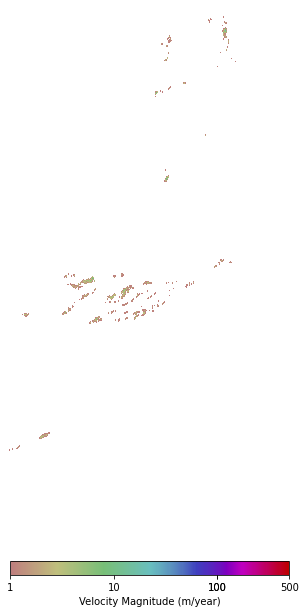

In [10]:
plt.figure(figsize=(10,12))
fig = plt.imshow(scaled_ds, origin='lower', cmap=cmap)
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
tickval = [1, 10, 100, 100, 500]
t = np.log(tickval)
cb = plt.colorbar(fig, ticks=255*(t - t[0])/(t[-1] - t[0]), shrink=0.5,orientation="horizontal")
cb.set_label('Velocity Magnitude (m/year)')
cb.ax.set_xticklabels(tickval)
plt.show()

## From 1 band GeoTIFF to RGBa GeoTIFF

In [15]:
# apply the colormap to the scaled data
rgb_ds = cmap(scaled_ds)
rgb_ds.shape

#free memory
scaled_ds = None
del scaled_ds

In [16]:
rgb_ds

array([[[0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        ...,
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ]],

       [[0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        ...,
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ]],

       [[0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        ...,
        [0.75      , 0.50776255, 0.4958002 , 1.        ],
        [0.75      , 0.507762

In [17]:
# rescale RGB values from [0,1] to [0,255]
data_array_scaled = np.interp(rgb_ds,(0, 1), (0, 255))
#free memory
rgb_ds = None
del rgb_ds

In [18]:
data_array_scaled

array([[[191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905156, 255.        ],
        ...,
        [191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905156, 255.        ]],

       [[191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905156, 255.        ],
        ...,
        [191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905156, 255.        ]],

       [[191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905156, 255.        ],
        [191.25      , 129.47944913, 126.42905

In [11]:
geotransform = src.GetGeoTransform ()
print('originX:',geotransform[0])
print('originY:',geotransform[3])
print('pixelWidth:',geotransform[1])
print('pixelHeight',geotransform[5])
print(data_array_scaled.shape[2]-1)
print(src.RasterXSize)
print(src.RasterYSize)

originX: -17430884.00370195
originY: 9340621.888272002
pixelWidth: 103.3619022032304
pixelHeight -103.3619022032304
3
23147
12667


In [19]:
# Creates a copy of a 3-band raster with values from array'''
# GeoTIFF creation options : https://gdal.org/drivers/raster/gtiff.html

# Destination file name 
rgb_file = in_file.replace('.tif','_rgb.tif')

# info from source
geotransform = src.GetGeoTransform ()
originX = geotransform[0]
originY = geotransform[3]
pixelWidth = geotransform[1]
pixelHeight = geotransform[5]
bands = data_array_scaled.shape[2]-1
rows = src.RasterXSize
cols = src.RasterYSize

# Get geotiff driver
driver = gdal.GetDriverByName('GTiff')
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF','COMPRESS=LZW','PREDICTOR=2']

# Create new raster
dest = driver.Create(rgb_file,rows,cols, bands, eType=gdal.GDT_Byte,options=options)
dest.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

# Set metadata.SetGeoTransform(src.GetGeoTransform())
dest.GetRasterBand(1).WriteArray(np.around(data_array_scaled[:,:,0]))
#dest.GetRasterBand(1).SetNoDataValue(255)
dest.GetRasterBand(2).WriteArray(np.around(data_array_scaled[:,:,1]))
#dest.GetRasterBand(2).SetNoDataValue(255)
dest.GetRasterBand(3).WriteArray(np.around(data_array_scaled[:,:,2]))
#dest.GetRasterBand(3).SetNoDataValue(255)
# loop through bands and write new values
#or bix in range(3):
#    destb = dest.GetRasterBand(bix+1)
#    #Write array
#    destb.WriteArray(rgb_data[:,:,bix])

destSRS = osr.SpatialReference()
destSRS.ImportFromEPSG(3857)
dest.SetProjection(destSRS.ExportToWkt())

# Close dataset
data_array_scaled= None
del data_array_scaled
dest = None
del dest

In [20]:
# add an alpha band to the RGB for transparent background in Mapbox
rgba_file =rgb_file.replace('rgb','rgba')
rgba_comp_file =rgba_file.replace('.tif','_comp.tif')

#create alpha band
options = gdal.WarpOptions(format='GTiff', srcNodata=255, dstAlpha=True)
dest = gdal.Warp(rgba_file, rgb_file, options=options)
dest = None

#compress GTiff
ds = gdal.Open(rgba_file)
tr_options = gdal.TranslateOptions(creationOptions = ['COMPRESS=LZW','PREDICTOR=2'])
ds = gdal.Translate(rgba_comp_file, ds,options=tr_options)
ds = None

In [14]:
#delete uncompress rgba_file
os.remove(rgba_file)
os.remove(rgb_file)

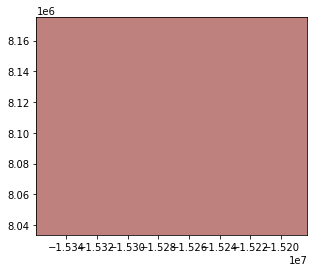

<AxesSubplot:>

In [21]:
fp = rgba_comp_file
img = rasterio.open(fp)
show(img)


In [25]:
img= None
del img